# Code

In [192]:
%pip install PyGithub python-dotenv pandas tqdm matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [193]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [194]:
# ORGANIZATIONS = ["googlesamples", "aws-samples", "Azure-Samples", "spring-guides", "googlearchive", "spring-cloud-samples"]
ORGANIZATIONS = ["googlesamples"]
EXCLUDED_REPOS = [
    "googlearchive/digits-migration-helper-android",
    "googlearchive/play-apk-expansion",
    "googlearchive/tiger",
    "googlearchive/two-token-sw",
    "googlearchive/Abelana-Android",
    "googlearchive/solutions-mobile-backend-starter-java"
]

In [195]:
load_dotenv()
github_client = Github(getenv('GITHUB_TOKEN'))

In [196]:
def fetch_organization_repositories(organization_name, language=None):
    organization = github_client.get_organization(organization_name)
    repositories = organization.get_repos("all")
    total_repositories = repositories.totalCount
    repo_data = []

    conut = 0

    for repo in tqdm(repositories, desc=organization_name, unit=" repos", total=total_repositories, ncols=100):
        if repo.full_name in EXCLUDED_REPOS:
            continue

        # if language and repo.language != language:
        #     continue

        if organization_name == "googlearchive" and not is_valid_googlearchive_repo(repo):
            continue
        elif organization_name == "SAP-samples" and not is_valid_sap_sample_repo(repo):
            continue

        repo_languages = repo.get_languages()
        total_lines = sum(repo_languages.values())
        language_percentages = {lang: f'{(lines/total_lines):.2%}' for lang, lines in repo_languages.items()}
        repo_data.append({
            "full_name": repo.full_name,
            "name": repo.name,
            "owner": repo.owner.login,
            "html_url": repo.html_url,
            "description": repo.description,
            "language": repo.language,
            "created_at": repo.created_at,
            "updated_at": repo.updated_at,
            "pushed_at": repo.pushed_at,
            "size": repo.size,
            "stargazers_count": repo.stargazers_count,
            "watchers_count": repo.watchers_count,
            "forks_count": repo.forks_count,
            "open_issues_count": repo.open_issues_count,
            "subscribers_count": repo.subscribers_count,
            "network_count": repo.network_count,
            "archived": repo.archived,
            "total_lines": total_lines,
            "langs_percentage": language_percentages
        })
        conut += 1
        
        # if conut == 3:
        #     break

    return pd.DataFrame(repo_data)

def is_valid_googlearchive_repo(repo):
    if not repo.description:
        return False
    keywords = ["example", "sample", "migrated"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)

def is_valid_sap_sample_repo(repo):
    if not repo.description:
        return False
    keywords = ["cloud"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)


In [197]:
def generate_metrics_csv():
    all_repos_data = pd.DataFrame()
    language_filter = None

    for organization in ORGANIZATIONS:
        print(f'Retrieving repos from {organization}...')
        organization_repos_data = fetch_organization_repositories(organization, language_filter)
        all_repos_data = pd.concat([all_repos_data, organization_repos_data], ignore_index=True)
        print(f'Done with {organization}')

    file_path = f"results/codesamples.csv"

    all_repos_data.to_csv(file_path, index=False)

    return all_repos_data

In [198]:
def calculate_language_usage(dataframe):
    language_usage = {}

    for repo in dataframe.itertuples():
        repo_languages = repo.langs_percentage
        total_lines = repo.total_lines

        for language, percentage in repo_languages.items():
            lines = total_lines * (float(percentage.strip('%')) / 100)
            language_usage[language] = language_usage.get(language, 0) + lines

    total_lines_of_code = sum(language_usage.values())

    formatted_languages = sorted(
        [(language, f'{(lines / total_lines_of_code):.2%}', int(lines)) for language, lines in language_usage.items()],
        key=lambda item: float(item[1].strip('%')),
        reverse=True
    )

    file_path = f"results/languages_usage.csv"
    dataframeLanguages = pd.DataFrame(formatted_languages, columns=["Language", "Usage Percentage", "Lines"])
    dataframeLanguages.to_csv(file_path, index=False)
    return dataframeLanguages


In [199]:
def generate_statistics(dataframe):    
    statistics = dataframe[METRICS].describe().transpose()
    
    statistics['median'] = dataframe[METRICS].median()
    statistics['mode'] = dataframe[METRICS].mode().iloc[0]
    
    file_path = f"results/statistics.csv"
    statistics.to_csv(file_path)
    
    return statistics

In [200]:
def plot_metrics_distribution():
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(METRICS):
        plt.subplot(3, 3, i + 1)
        sns.histplot(dataframe[metric], kde=True, bins=30, color='blue', alpha=0.6)
        plt.axvline(dataframe[metric].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(dataframe[metric].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.savefig('results/distribution_metrics.png')
    plt.show()

In [ ]:
def plot_boxplot_metrics():
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(METRICS):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(x=dataframe[metric], color='lightblue')
        plt.title(f'Boxplot of {metric}')
        plt.xlabel(metric)

    plt.tight_layout()
    plt.savefig('results/boxplot_metrics.png')
    plt.show()

# Results

In [201]:
METRICS = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count', 
    'open_issues_count', 
    'subscribers_count', 
    'network_count', 
    'total_lines'
]

In [202]:
dataframe = generate_metrics_csv()
dataframe

Retrieving repos from googlesamples...


googlesamples: 100%|████████████████████████████████████████████| 71/71 [01:21<00:00,  1.15s/ repos]

Done with googlesamples


,full_name,name,owner,html_url,description,language,created_at,updated_at,pushed_at,size,stargazers_count,watchers_count,forks_count,open_issues_count,subscribers_count,network_count,archived,total_lines,langs_percentage
0,googlesamples/web-fundamentals,web-fundamentals,googlesamples,https://github.com/googlesamples/web-fundamentals,Google Web Fundamentals,HTML,2014-05-13 22:08:22+00:00,2024-07-19 03:15:02+00:00,2020-12-04 17:51:23+00:00,69887,309,309,201,5,48,201,False,420286,"{'HTML': '92.67%', 'JavaScript': '3.94%', 'CSS..."
1,googlesamples/io2014-codelabs,io2014-codelabs,googlesamples,https://github.com/googlesamples/io2014-codelabs,Google I/O 2014 Codelabs,Java,2014-06-14 01:43:21+00:00,2023-01-27 22:48:55+00:00,2015-08-30 03:40:54+00:00,3870,177,177,56,6,29,56,True,766343,"{'Java': '77.74%', 'JavaScript': '10.70%', 'Go..."
2,googlesamples/android-play-publisher-api,android-play-publisher-api,googlesamples,https://github.com/googlesamples/android-play-...,None,Java,2014-07-03 01:26:35+00:00,2024-06-17 19:59:05+00:00,2023-04-13 11:24:34+00:00,30,491,491,286,46,56,286,True,45818,"{'Java': '65.85%', 'Python': '34.15%'}"
3,googlesamples/identity-toolkit-java,identity-toolkit-java,googlesamples,https://github.com/googlesamples/identity-tool...,None,Java,2014-07-18 18:19:18+00:00,2024-04-16 22:52:50+00:00,2015-12-21 22:44:47+00:00,6543,23,23,24,2,23,24,True,6144,"{'Java': '78.16%', 'HTML': '21.84%'}"
4,googlesamples/identity-toolkit-ruby,identity-toolkit-ruby,googlesamples,https://github.com/googlesamples/identity-tool...,None,HTML,2014-07-18 18:20:43+00:00,2023-01-27 22:48:55+00:00,2015-08-31 19:34:44+00:00,137,4,4,12,0,16,12,True,3780,"{'HTML': '52.57%', 'Ruby': '47.43%'}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,googlesamples/.github,.github,googlesamples,https://github.com/googlesamples/.github,None,None,2022-10-26 03:32:10+00:00,2024-03-29 09:13:59+00:00,2022-10-26 03:32:12+00:00,0,1,1,0,0,5,0,True,0,{}
67,googlesamples/subgraph_sdk_sample,subgraph_sdk_sample,googlesamples,https://github.com/googlesamples/subgraph_sdk_...,None,Kotlin,2022-12-15 03:54:35+00:00,2024-05-30 09:51:23+00:00,2024-03-25 16:29:58+00:00,289,6,6,1,0,3,1,False,11785,{'Kotlin': '100.00%'}
68,googlesamples/zero-touch-enrollment-colabs,zero-touch-enrollment-colabs,googlesamples,https://github.com/googlesamples/zero-touch-en...,None,Jupyter Notebook,2023-08-18 17:50:21+00:00,2024-05-30 10:08:35+00:00,2023-09-27 16:53:44+00:00,13,1,1,1,0,2,1,False,18098,{'Jupyter Notebook': '100.00%'}
69,googlesamples/engage-sdk-samples,engage-sdk-samples,googlesamples,https://github.com/googlesamples/engage-sdk-sa...,Set of sample apps that demonstrate how to int...,Java,2023-08-25 04:18:25+00:00,2024-05-30 09:34:44+00:00,2024-04-05 17:17:29+00:00,286,4,4,2,1,7,2,False,240386,"{'Java': '50.68%', 'Kotlin': '49.32%'}"


In [203]:
dataframeLanguages = calculate_language_usage(dataframe)
dataframeLanguages

,Language,Usage Percentage,Lines
0,Java,34.27%,6135907
1,C#,18.11%,3242684
2,C++,17.23%,3084393
3,Kotlin,6.05%,1083540
4,Objective-C,5.32%,951629
5,JavaScript,4.27%,764900
6,Python,3.10%,555793
7,C,2.90%,518418
8,HTML,2.86%,512118
9,Swift,2.18%,390122


In [204]:
dataframe_statistics = generate_statistics(dataframe)
dataframe_statistics

,count,mean,std,min,25%,50%,75%,max,median,mode
size,71.0,13870.746479,40875.044923,0.0,111.5,289.0,3267.5,253911.0,289.0,0.0
stargazers_count,71.0,474.830986,1320.954330,1.0,10.0,68.0,429.0,9842.0,68.0,2.0
watchers_count,71.0,474.830986,1320.954330,1.0,10.0,68.0,429.0,9842.0,68.0,2.0
forks_count,71.0,188.281690,511.691653,0.0,9.0,27.0,142.5,2907.0,27.0,5.0
open_issues_count,71.0,22.690141,53.030070,0.0,0.0,3.0,13.0,322.0,3.0,0.0
subscribers_count,71.0,35.788732,55.622687,2.0,8.5,18.0,36.5,286.0,18.0,8.0
network_count,71.0,188.281690,511.691653,0.0,9.0,27.0,142.5,2907.0,27.0,5.0
total_lines,71.0,252151.577465,559229.041096,0.0,9815.5,39914.0,191474.0,3355495.0,39914.0,0.0


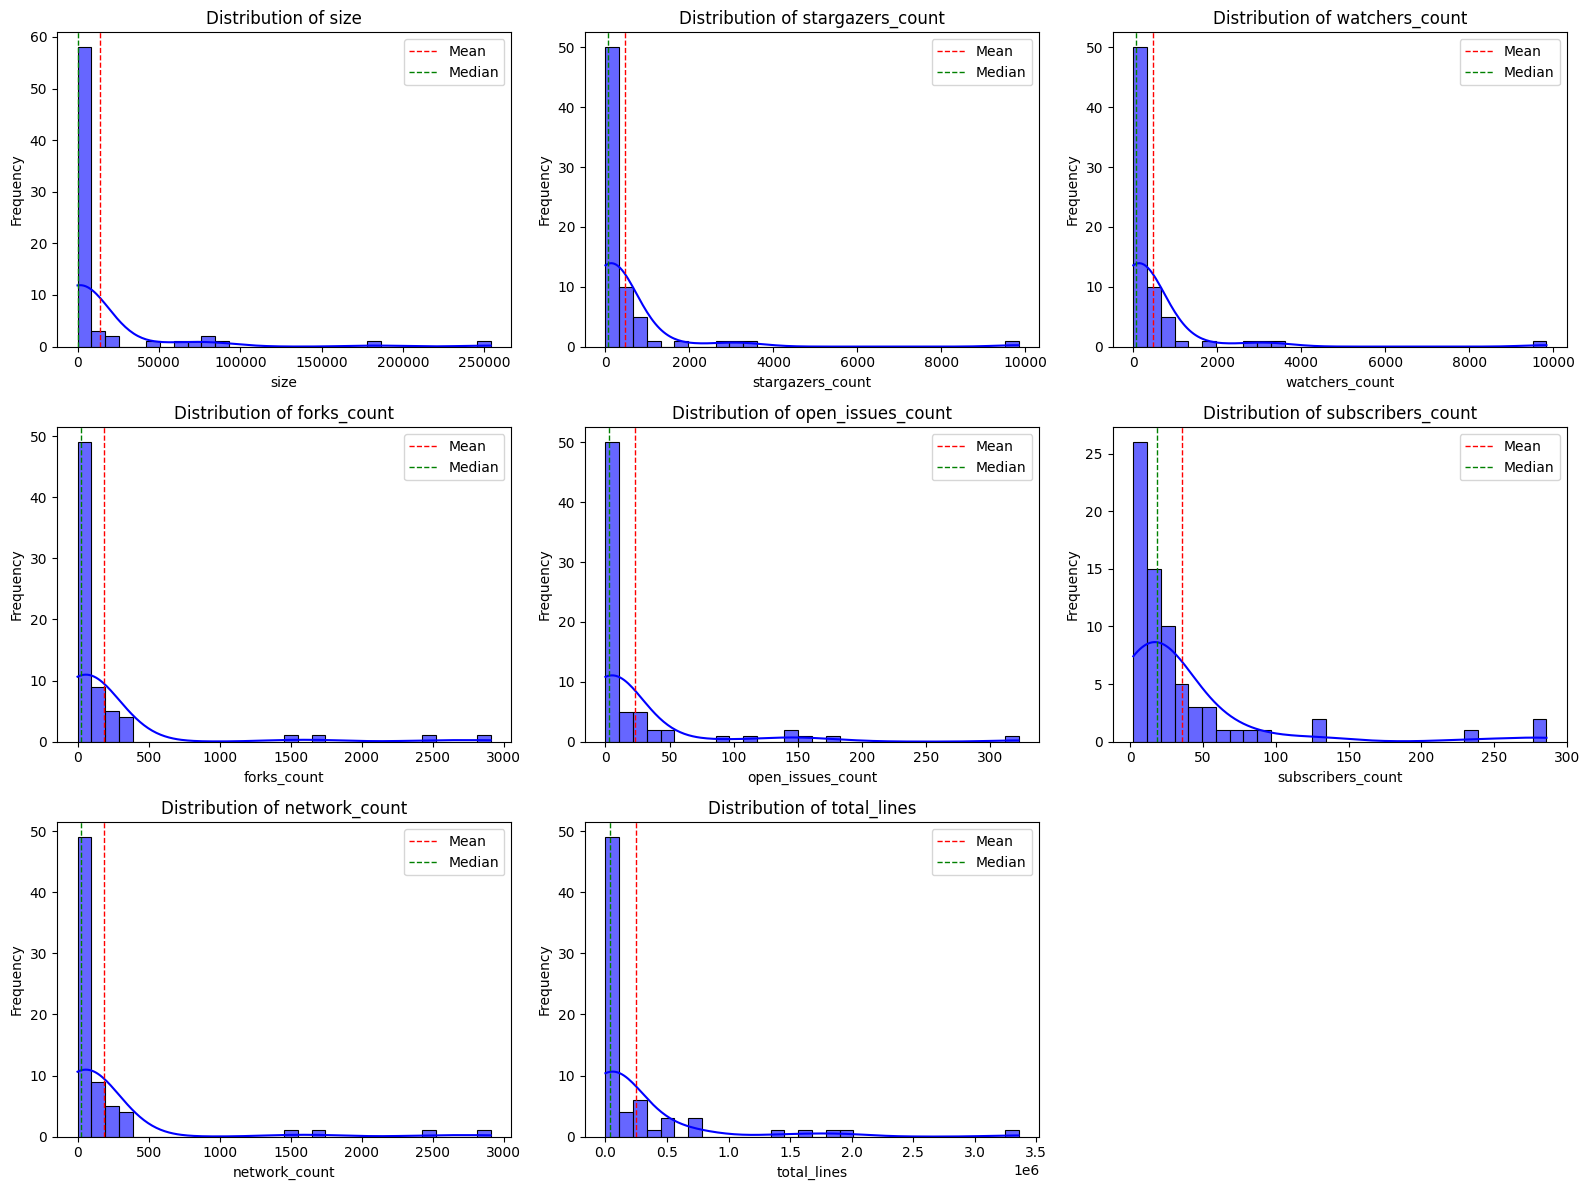

In [205]:
plot_metrics_distribution()

In [ ]:
plot_boxplot_metrics()